In [48]:
import sys 
sys.path.append('..')
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
import numpy as np
import torch as ch
from torch import Tensor
from torch.distributions import Uniform
from torch.distributions.transforms import SigmoidTransform
from torch.distributions.transformed_distribution import TransformedDistribution
from torch.utils.data import DataLoader
from delphi.stats.truncated_logistic_regression import truncated_logistic_regression
from delphi.utils.datasets import TruncatedLogisticRegressionDataset
from delphi.oracle import Left, Interval
import datetime

# Helpers

In [101]:
STORE_PATH = '/home/pstefanou/LogisticRegression'
STORE_TABLE_NAME = 'logistic100'

store = Store(STORE_PATH)

store.add_table(STORE_TABLE_NAME, { 
    'delphi_cos': float,
    'mle_cos': float,
    'alpha': float, 
    'C': float,
})

Logging in: /home/pstefanou/LogisticRegression/51e47e62-79a4-4bf9-88d2-4d67584f902f


## Default Experiment Parameters

In [102]:
# regression parameters
NUM_SAMPLES, DIMS = 10000, 2
LOWER, UPPER = -1, 1

# procedure hyperparameters
args = Parameters({ 
    'epochs': 25,
    'num_workers': 0, 
    'batch_size': 10,
    'bias': True,
    'num_samples': 100,
    'clamp': True, 
    'radius': 5.0, 
    'var_lr': 1e-2,
    'lr': 1e-1,
    'shuffle': False, 
    'tol': 5e-3,
})

# Logistic Distribution

In [103]:
# define logistic distribution
base_distribution = Uniform(0, 1)
transforms_ = [SigmoidTransform().inv]
logistic = TransformedDistribution(base_distribution, transforms_)

In [104]:
# perform each experiment a total of 10 times
for iter_ in range(100): 
    for C in [-2, -.5, -1, -.5]:
        PREDICATE = Left(Tensor([C]))
        args.__setattr__('phi', PREDICATE)
        # generate random uniform weights
        W = Uniform(LOWER, UPPER).sample(ch.Size([DIMS, 1]))
        W0 = Uniform(LOWER, UPPER).sample(ch.Size([1, 1]))

        # generate data
        X = Uniform(-100, 100).sample(ch.Size([NUM_SAMPLES, DIMS]))
        z = X.mm(W) + W0 + logistic.sample(ch.Size([NUM_SAMPLES, 1]))
        y = ch.where(z > 0, 1.0, 0.0)
        # truncate
        indices = PREDICATE(z).nonzero(as_tuple=False).flatten()
        z_trunc, y_trunc, x_trunc = z[indices], y[indices], X[indices]

        args.__setattr__('alpha', Tensor([y_trunc.size(0) / NUM_SAMPLES]))

        # truncated logistic regression
        data = TruncatedLogisticRegressionDataset(x_trunc, y_trunc, bias=args.bias)
        S = DataLoader(data, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=args.shuffle)
        trunc_log_reg = truncated_logistic_regression(phi=args.phi, alpha=args.alpha, bias=args.bias, epochs=args.epochs, 
                                                      lr=args.lr, num_samples=args.num_samples, tol=args.tol)
        results = trunc_log_reg.fit(S)
        w, w0 = results.weight.detach().cpu(), results.bias.detach().cpu()

        # parameter estimates 
        real_params = ch.cat([W.T, W0], axis=1)
        mle_params = ch.cat([data.w, data.w0.unsqueeze(0)], axis=1)
        delphi_params = ch.cat([w, w0.unsqueeze(0)], axis=1)

        # metrics
        mle_cos = cosine_similarity(mle_params, real_params)
        delphi_cos = cosine_similarity(delphi_params, real_params)

        store[STORE_TABLE_NAME].append_row({ 
            'delphi_cos': delphi_cos,
            'mle_cos': mle_cos,
            'alpha': float(args.alpha),
            'C': C,
        })

# close current store
store.close()

# Results

In [99]:
reader = CollectionReader(STORE_PATH)
results = reader.df(STORE_TABLE_NAME)
reader.close() # close reader
results.head()

100%|██████████| 6/6 [00:00<00:00, 216.89it/s]

,delphi_cos,mle_cos,alpha,C,exp_id
0,0.848419,0.898514,0.5101,-2.0,4107e665-1d0c-4e0a-aa92-9cb1055f4483
1,0.219919,0.219879,0.4923,-0.5,4107e665-1d0c-4e0a-aa92-9cb1055f4483
2,0.817827,0.888453,0.5084,-1.0,4107e665-1d0c-4e0a-aa92-9cb1055f4483
3,0.479737,0.479652,0.5006,-0.5,4107e665-1d0c-4e0a-aa92-9cb1055f4483
4,0.997195,0.991031,0.5154,-2.0,4107e665-1d0c-4e0a-aa92-9cb1055f4483


# All Trials

all trials:


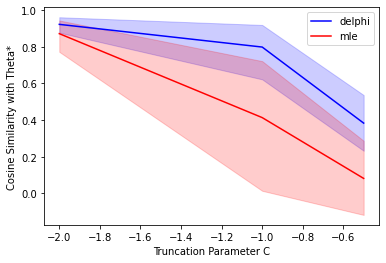

In [100]:
print("all trials:")

# variance vs param mse
sns.lineplot(data=results, x='C', y='delphi_cos', label='delphi', color='blue')
ax = sns.lineplot(data=results, x='C', y='mle_cos', label='mle', color='red')
ax.set(xlabel='Truncation Parameter C', ylabel='Cosine Similarity with Theta*')
plt.show()

# Remove Best and Worst Trial from Results

In [55]:
print("remove best and worst trials:")

# plot results for regression parameter MSE
sns.lineplot(data=results.drop(noise_lambda('unknown_param_mse')), x='var', y='unknown_param_mse', label='unknown', color='blue')
sns.lineplot(data=results.drop(noise_lambda('known_param_mse')), x='var', y='known_param_mse', label='known', color='purple')
ax = sns.lineplot(data=results.drop(noise_lambda('ols_param_mse')), x='var', y='ols_param_mse', label='ols', color='red')
ax.set(xlabel='Noise Variance', ylabel='Squared Error Theta*')
plt.show()

# plot results for regression parameter MSE
sns.lineplot(data=results.drop(noise_lambda('unknown_var_mse')), x='var', y='unknown_var_mse', label='unknown', color='blue')
ax = sns.lineplot(data=results.drop(noise_lambda('ols_var_mse')), x='var', y='ols_var_mse', label='ols', color='red')
ax.set(xlabel='Noise Variance', ylabel='Squared Error Sigma^2*')
plt.show()

remove best and worst trials:


NameError: name 'noise_lambda' is not defined

In [95]:
s = Store('/home/pstefanou/LogisticRegression/', 'ae6627d0-9b20-49ca-9aca-73d0a07637c0')

In [97]:
s.close()